# Advanced DDPG: Integrating Clipped Double Q-Learning

The traditional **Deep Deterministic Policy Gradient (DDPG)** algorithm is a model-free, off-policy actor-critic method using deep function approximators that can learn policies in high-dimensional, continuous action spaces. However, it can suffer from overestimation bias due to the single critic architecture.

**Clipped Double Q-Learning**, originally popularized by the TD3 (Twin Delayed DDPG) algorithm, modifies this by using two critic networks. Here's how it differs from standard DDPG:

- **Dual Critic Networks**: Instead of one, there are two critic networks (and two target critics). This dual architecture helps in reducing overestimation by taking the minimum value of the two critic estimates during the update phase.
- **Clipped Double Q-Update**: When updating the critic, the lesser of the two critic values is used, which is believed to yield a more stable and reliable learning signal than using a single estimate.

By integrating Clipped Double Q-Learning into DDPG, we aim to enhance stability and performance, particularly in environments with high variance in reward structures and complex, multi-dimensional action spaces.


In [62]:
pip install swig

In [63]:
pip install gym[box2d]

In [64]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np

In [65]:
# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# LunarLander Environment Overview

The **LunarLander** environment, provided by OpenAI Gym, offers a simulation where an agent is tasked with the safe landing of a spacecraft on a specified landing pad. The environment is designed to mimic the challenges of actual lunar landing by providing various rewards and penalties based on the agent's actions:

- **Landing Reward**: Successfully navigating to the landing pad and deactivating the engines secures a substantial reward for the agent.
- **Safe Landing Bonus**: Achieving a safe landing, where the lander maintains stability and accuracy on the landing pad, earns a significant positive reward.
- **Unsafe Landing Penalty**: An unsafe landing, where the lander crashes or comes to rest in an incorrect position, results in a large negative reward.
- **Fuel Usage Penalty**: Each use of the engines incurs a small negative reward, simulating fuel consumption and encouraging fuel-efficient maneuvers.

## Variants of LunarLander

LunarLander is available in two variants within the OpenAI Gym:

- **Discrete LunarLander**: The discrete version allows the agent to make decisions from a set of discrete actions (such as firing specific engines).
- **Continuous LunarLander**: In the continuous version, the agent has more granular control, with the ability to adjust the thrust of two main engines anywhere within a continuous range from -1 to 1. This version demands a more precise control mechanism and is often more challenging due to the fine-tuned action space.

The continuous version, in particular, is an excellent testbed for reinforcement learning algorithms that can handle continuous action spaces, such as DDPG (Deep Deterministic Policy Gradient) or the enhanced versions with Clipped Double Q-Learning.


In [66]:
import gym
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image  # To display the GIF in the notebook
# Create the LunarLander environment
env = gym.make('LunarLanderContinuous-v2')
env.reset()

frames = []

for _ in range(200):  # You might adjust the number of frames based on your needs
    frame = env.render(mode='rgb_array')
    frames.append(frame)
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if done:
        env.reset()

env.close()

def make_animation(frames):
    fig = plt.figure()
    plt.axis('off')  # Turn off the axis
    ims = [[plt.imshow(frame, animated=True)] for frame in frames]

    anim = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    plt.close(fig)
    return anim

anim = make_animation(frames)
anim.save('lunar_lander.gif', writer='imagemagick', fps=30)  # fps controls the speed of the GIF

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


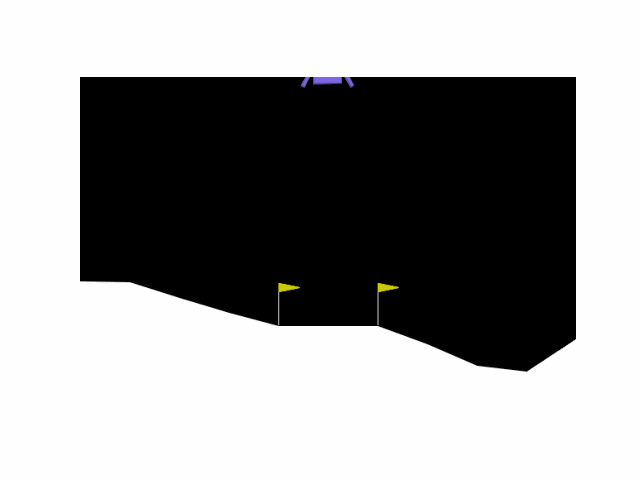

In [67]:
# Display the GIF in the notebook
Image(filename='lunar_lander.gif')


Implementing Replay Buffers for Enhanced Learning

In [68]:
class ExperienceBuffer():
    def __init__(self, capacity=1e6):
        self.buffer = []
        self.capacity = int(capacity)
        self.cursor = 0

    def store(self, transition):
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.cursor] = transition
            self.cursor = (self.cursor + 1) % self.capacity

    def retrieve_sample(self, batch_size):
        indices = np.random.randint(0, len(self.buffer), size=batch_size)
        states, next_states, actions, rewards, dones = [], [], [], [], []

        for idx in indices:
            state, next_state, action, reward, done = self.buffer[idx]
            states.append(np.array(state, copy=False))
            next_states.append(np.array(next_state, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(np.array(reward, copy=False))
            dones.append(np.array(done, copy=False))

        return map(np.array, [states, next_states, actions, rewards.reshape(-1,1), dones.reshape(-1,1)])


### Development of DDPG with a Clipped Double Q Learning Model

In [69]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.max_action * torch.tanh(self.fc3(x))

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(Critic, self).__init__()
        # First critic network
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        # Second critic network
        self.fc4 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        xu = torch.cat([state, action], dim=1)
        # First critic network
        x1 = F.relu(self.fc1(xu))
        x1 = F.relu(self.fc2(x1))
        x1 = self.fc3(x1)
        # Second critic network
        x2 = F.relu(self.fc4(xu))
        x2 = F.relu(self.fc5(x2))
        x2 = self.fc6(x2)
        return x1, x2

### DDPG Agent: Class Structure

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

class PolicyActor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, max_action):
        super(PolicyActor, self).__init__()
        self.layer1 = nn.Linear(state_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.layer1(state))
        x = F.relu(self.layer2(x))
        return torch.tanh(self.layer3(x)) * self.max_action

class ValueCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(ValueCritic, self).__init__()
        # First critic
        self.layer1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.output1 = nn.Linear(hidden_dim, 1)
        # Second critic
        self.layer3 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.layer4 = nn.Linear(hidden_dim, hidden_dim)
        self.output2 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        xu = torch.cat([state, action], dim=1)
        x1 = F.relu(self.layer1(xu))
        x1 = F.relu(self.layer2(x1))
        x1 = self.output1(x1)
        x2 = F.relu(self.layer3(xu))
        x2 = F.relu(self.layer4(x2))
        x2 = self.output2(x2)
        return x1, x2

class DDPG:
    def __init__(self, state_dim, action_dim, hidden_dim, actor_lr, critic_lr, discount, min_action, max_action, exploration_noise):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.actor = PolicyActor(state_dim, action_dim, hidden_dim, max_action).to(self.device)
        self.actor_target = PolicyActor(state_dim, action_dim, hidden_dim, max_action).to(self.device)
        self.critic = ValueCritic(state_dim, action_dim, hidden_dim).to(self.device)
        self.critic_target = ValueCritic(state_dim, action_dim, hidden_dim).to(self.device)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.discount = discount
        self.min_action = min_action
        self.max_action = max_action
        self.exploration_noise = exploration_noise

        self.soft_update_networks(tau=1.0)  # Initialize target networks with the same weights

    def select_action(self, state):
        state = torch.FloatTensor(state).to(self.device)
        self.actor.eval()  # Set the network into evaluation mode
        with torch.no_grad():
            action = self.actor(state)
        self.actor.train()  # Set the network back to training mode
        action += torch.randn_like(action) * self.exploration_noise
        return action.clamp(self.min_action, self.max_action).cpu().numpy()

    def train(self, replay_buffer, batch_size):
        state_batch, next_state_batch, action_batch, reward_batch, not_done_batch = replay_buffer.sample(batch_size)

        next_action_batch = None
        target_q = None
        with torch.no_grad():
            next_action_batch = self.actor_target(next_state_batch)
            target_q1, target_q2 = self.critic_target(next_state_batch, next_action_batch)
            target_q = torch.min(target_q1, target_q2)
            target_q = reward_batch + not_done_batch * self.discount * target_q

        current_q1, current_q2 = self.critic(state_batch, action_batch)
        critic_loss = F.mse_loss(current_q1, target_q) + F.mse_loss(current_q2, target_q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -self.critic(state_batch, self.actor(state_batch))[0].mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        return actor_loss.item(), critic_loss.item()

    def soft_update_networks(self, tau=0.005):
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

In [71]:
# Initialize env and set up hyperparameters
env = gym.make('LunarLanderContinuous-v2')
action_size = env.action_space.shape[0]
state_size = env.observation_space.shape[0]
min_action = env.action_space.low[0]
max_action = env.action_space.high[0]

# set seed
seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# create replay buffer
replay_size = 50000 # size of replay buffer
replay_buffer = ReplayBuffer(max_size=replay_size)

# target update hyperparameters
start_training_after = 10001 # start training NN after this many timesteps
update_target_every = 1 # update target network every this steps
tau = 0.001

episodes = 5000
discount = 0.99
batch_size = 32
exploration_noise = 0.1
hidden_size = 64
actor_lr = 0.0005
critic_lr = 0.0005
reward_scale = 0.01

# create DDPG Agent
agent = DDPGAgent(state_size=state_size, action_size=action_size, hidden_size=hidden_size,
                  actor_lr=actor_lr, critic_lr=critic_lr, discount=discount, min_action=min_action,
                  max_action=max_action, exploration_noise=exploration_noise)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


### Reinforcement Learning (RL) Training Process

The RL training loop is an iterative process where the agent engages with its environment through episodes and timesteps. During each iteration, the agent proceeds through the specified number of episodes, assessing and acting at each timestep. Training continues until it meets predefined stopping criteria, such as reaching a maximum number of episodes or timesteps, or achieving a particular performance threshold.

Within each episode, the following key activities occur at every timestep:

- **Action Selection**: The agent selects an action based on the current state using its policy.
- **Environment Interaction**: It then sends this action to the environment (`env.step()`), which returns the new state, reward, and whether the episode has ended (done).
- **Experience Storage**: This data (state, action, reward, next state, done) is stored in the replay buffer, a data structure designed to store past experiences.
- **Network Training**: The agent periodically trains its neural network with samples drawn from the replay buffer to improve its policy. This helps the agent learn from past actions and outcomes, optimizing its decision-making process.
- **Target Network Updates**: Periodically, the agent also updates the target network, which helps in stabilizing the learning updates.

When an episode concludes, typically marked by the `done` state from the environment, the environment is reset to start a new episode. This cycle of action, observation, and learning continues until the training loop is terminated based on the defined criteria.


In [72]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
stats_actor_loss, stats_critic_loss = [], []

for ep in range(episodes):
    state = env.reset()

    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break

    # train in each episode until episode is done
    while True:
        timesteps += 1
        #env.render()
        # select an action from the agent's policy
        action = agent.select_action(state)

        # enter action into the env
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        episode_length += 1
        # end episode early
        if total_reward < -250:
            done = 1

        # add experience to replay buffer
        replay_buffer.add((state, next_state, action, reward*reward_scale, 1-float(done)))

        # train the agent
        if timesteps >= start_training_after:
            actor_loss, critic_loss = agent.train(replay_buffer, batch_size)
            stats_actor_loss.append(actor_loss)
            stats_critic_loss.append(critic_loss)
            agent.update_target_network_soft(timesteps, update_target_every)

        if done:
            stats_rewards_list.append((ep, total_reward, episode_length))
            total_reward = 0
            episode_length = 0
            if timesteps >= start_training_after and ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    'Timestep: {}'.format(timesteps),
                    'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    'Actor Loss: {:.4f}'.format(np.mean(stats_actor_loss)),
                    'Critic Loss: {:.4f}'.format(np.mean(stats_critic_loss)))
                stats_actor_loss, stats_critic_loss = [], []
            break

        state = next_state

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 90 Timestep: 10189 Total reward: -182.5 Episode length: 111.4 Actor Loss: 0.1273 Critic Loss: 0.0156
Episode: 100 Timestep: 11043 Total reward: -216.5 Episode length: 85.4 Actor Loss: 0.1388 Critic Loss: 0.0099
Episode: 110 Timestep: 12116 Total reward: -138.3 Episode length: 107.3 Actor Loss: 0.1470 Critic Loss: 0.0076
Episode: 120 Timestep: 13473 Total reward: -206.5 Episode length: 135.7 Actor Loss: 0.1599 Critic Loss: 0.0062
Episode: 130 Timestep: 14835 Total reward: -192.8 Episode length: 136.2 Actor Loss: 0.1710 Critic Loss: 0.0051
Episode: 140 Timestep: 16150 Total reward: -238.6 Episode length: 131.5 Actor Loss: 0.1844 Critic Loss: 0.0052
Episode: 150 Timestep: 17632 Total reward: -155.4 Episode length: 148.2 Actor Loss: 0.1905 Critic Loss: 0.0049
Episode: 160 Timestep: 19203 Total reward: -184.7 Episode length: 157.1 Actor Loss: 0.1997 Critic Loss: 0.0043
Episode: 170 Timestep: 20680 Total reward: -124.5 Episode length: 147.7 Actor Loss: 0.2049 Critic Loss: 0.0044
Epi

KeyboardInterrupt: 

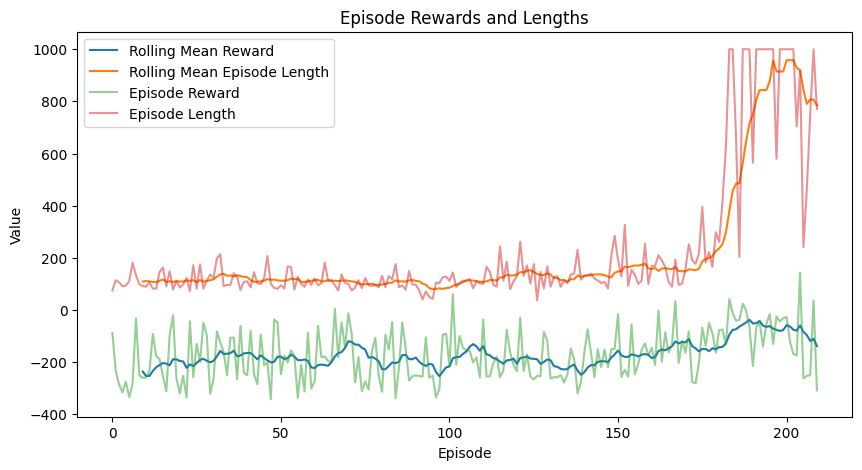

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert list to DataFrame
df = pd.DataFrame(stats_rewards_list, columns=['episode', 'reward', 'length'])

# Calculate rolling mean
rolling_mean_reward = df['reward'].rolling(window=10, center=False).mean()
rolling_mean_length = df['length'].rolling(window=10, center=False).mean()

# Plot the results
plt.figure(figsize=(10, 5))

# Plot rolling averages
plt.plot(df['episode'], rolling_mean_reward, label='Rolling Mean Reward')
plt.plot(df['episode'], rolling_mean_length, label='Rolling Mean Episode Length')

# Plot original data with transparency
plt.plot(df['episode'], df['reward'], alpha=0.5, label='Episode Reward')
plt.plot(df['episode'], df['length'], alpha=0.5, label='Episode Length')

plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('Episode Rewards and Lengths')
plt.legend()
plt.show()


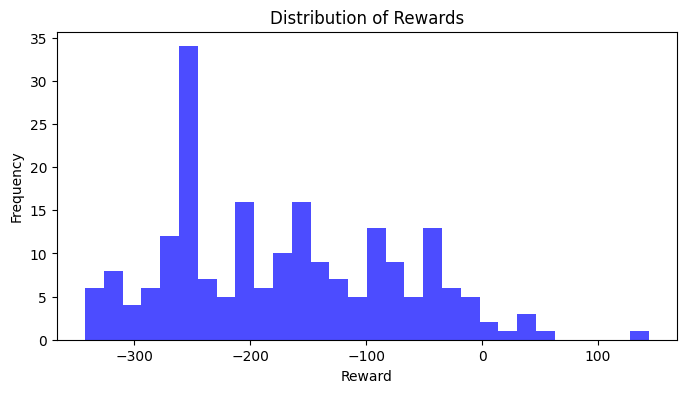

In [76]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your DataFrame with 'reward' and 'episode' columns
plt.figure(figsize=(8, 4))
plt.hist(df['reward'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Rewards')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.show()


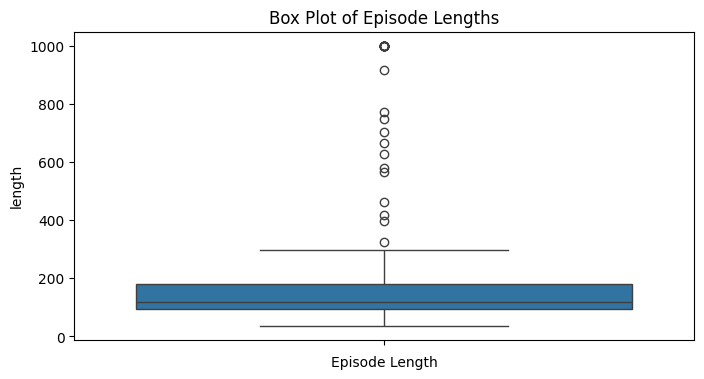

In [77]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.boxplot(data=df['length'])
plt.title('Box Plot of Episode Lengths')
plt.xlabel('Episode Length')
plt.show()


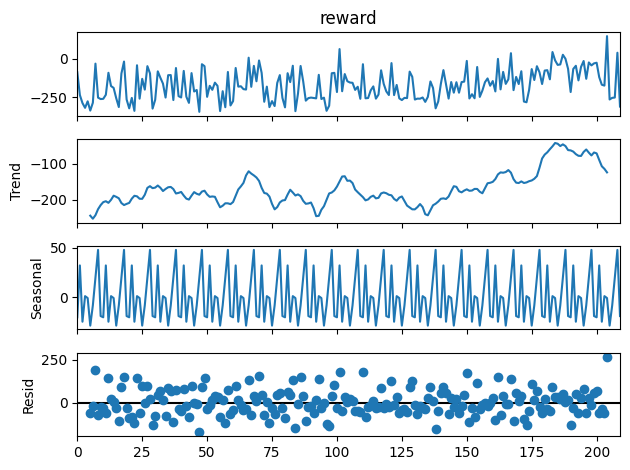

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series data
result = seasonal_decompose(df['reward'], model='additive', period=10)
result.plot()
plt.show()


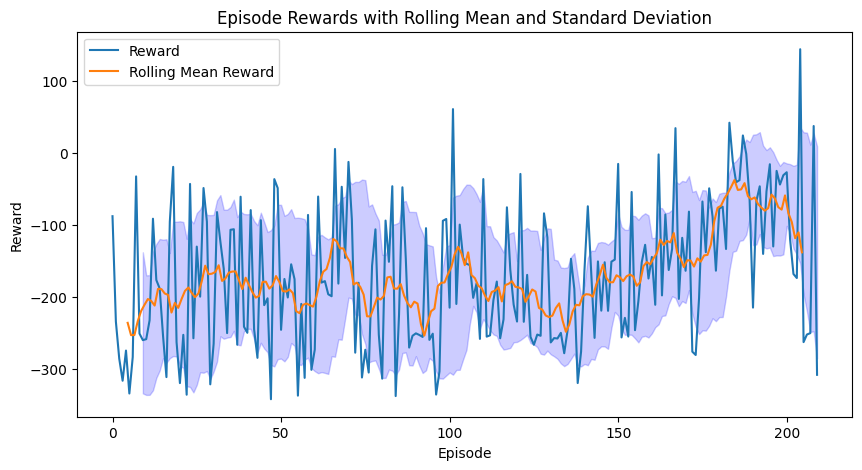

In [79]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='episode', y='reward', data=df, label='Reward')
sns.lineplot(x='episode', y='reward', data=df.rolling(window=10).mean(), label='Rolling Mean Reward')
plt.fill_between(df['episode'], df['reward'].rolling(10).mean() - df['reward'].rolling(10).std(),
                 df['reward'].rolling(10).mean() + df['reward'].rolling(10).std(), color='blue', alpha=0.2)
plt.title('Episode Rewards with Rolling Mean and Standard Deviation')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()


In [80]:
import plotly.express as px

fig = px.line(df, x='episode', y='reward', title='Interactive Reward Chart Over Episodes')
fig.update_xaxes(title_text='Episode')
fig.update_yaxes(title_text='Reward')
fig.show()
